In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)
import sys

sys.path.append("../")
from train_model import PARAMETERS

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [2]:
DEFAULT_WS = PARAMETERS["window_size"]
print(DEFAULT_WS)

20


In [3]:
Xnormal, Ynormal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
Xpainco, Ypainco = folder_to_sequence("PAINCO", DEFAULT_WS)
Xmenos, Ymenos = folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS)

Xscaler = MinMaxScaler_AE()
Yscaler = MinMaxScaler_AE()

Xscaler.fit(Xnormal)
Yscaler.fit(Ynormal)

Xnormal = Xscaler.transform(Xnormal)
Xpainco = Xscaler.transform(Xpainco)
Xmenos = Xscaler.transform(Xmenos)

Ynormal = Yscaler.transform(Ynormal)
Ypainco = Yscaler.transform(Ypainco)
Ymenos = Yscaler.transform(Ymenos)

seq2seq = keras.models.load_model("../models/best_model.keras")

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 41.36it/s]


In [4]:
from joblib import Parallel, delayed


# Function to perform a single stochastic forward pass with dropout
def stochastic_forward_pass(model, X_test):
    return model(X_test, training=True).numpy()


# Function to perform MC Dropout with parallel computation
def mc_dropout_predict_parallel(model, X_test, n_forward_passes=100, n_jobs=-1):
    # Use joblib to run parallel forward passes
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(stochastic_forward_pass)(model, X_test) for _ in range(n_forward_passes)
    )

    # Convert predictions list into numpy array
    predictions = np.array(
        predictions
    )  # Shape: (n_forward_passes, n_samples, time_steps)

    # Compute mean and uncertainty (standard deviation)
    mean_prediction = np.mean(predictions, axis=0)  # Mean across forward passes
    assert mean_prediction.shape[1] == X_test.shape[1], f"Shape mismatch: {mean_prediction.shape} != {X_test.shape}"

    uncertainty = np.std(predictions, axis=0)  # Uncertainty (std dev)

    return mean_prediction, uncertainty

In [5]:
Xmenos.shape

(8665, 20, 1)

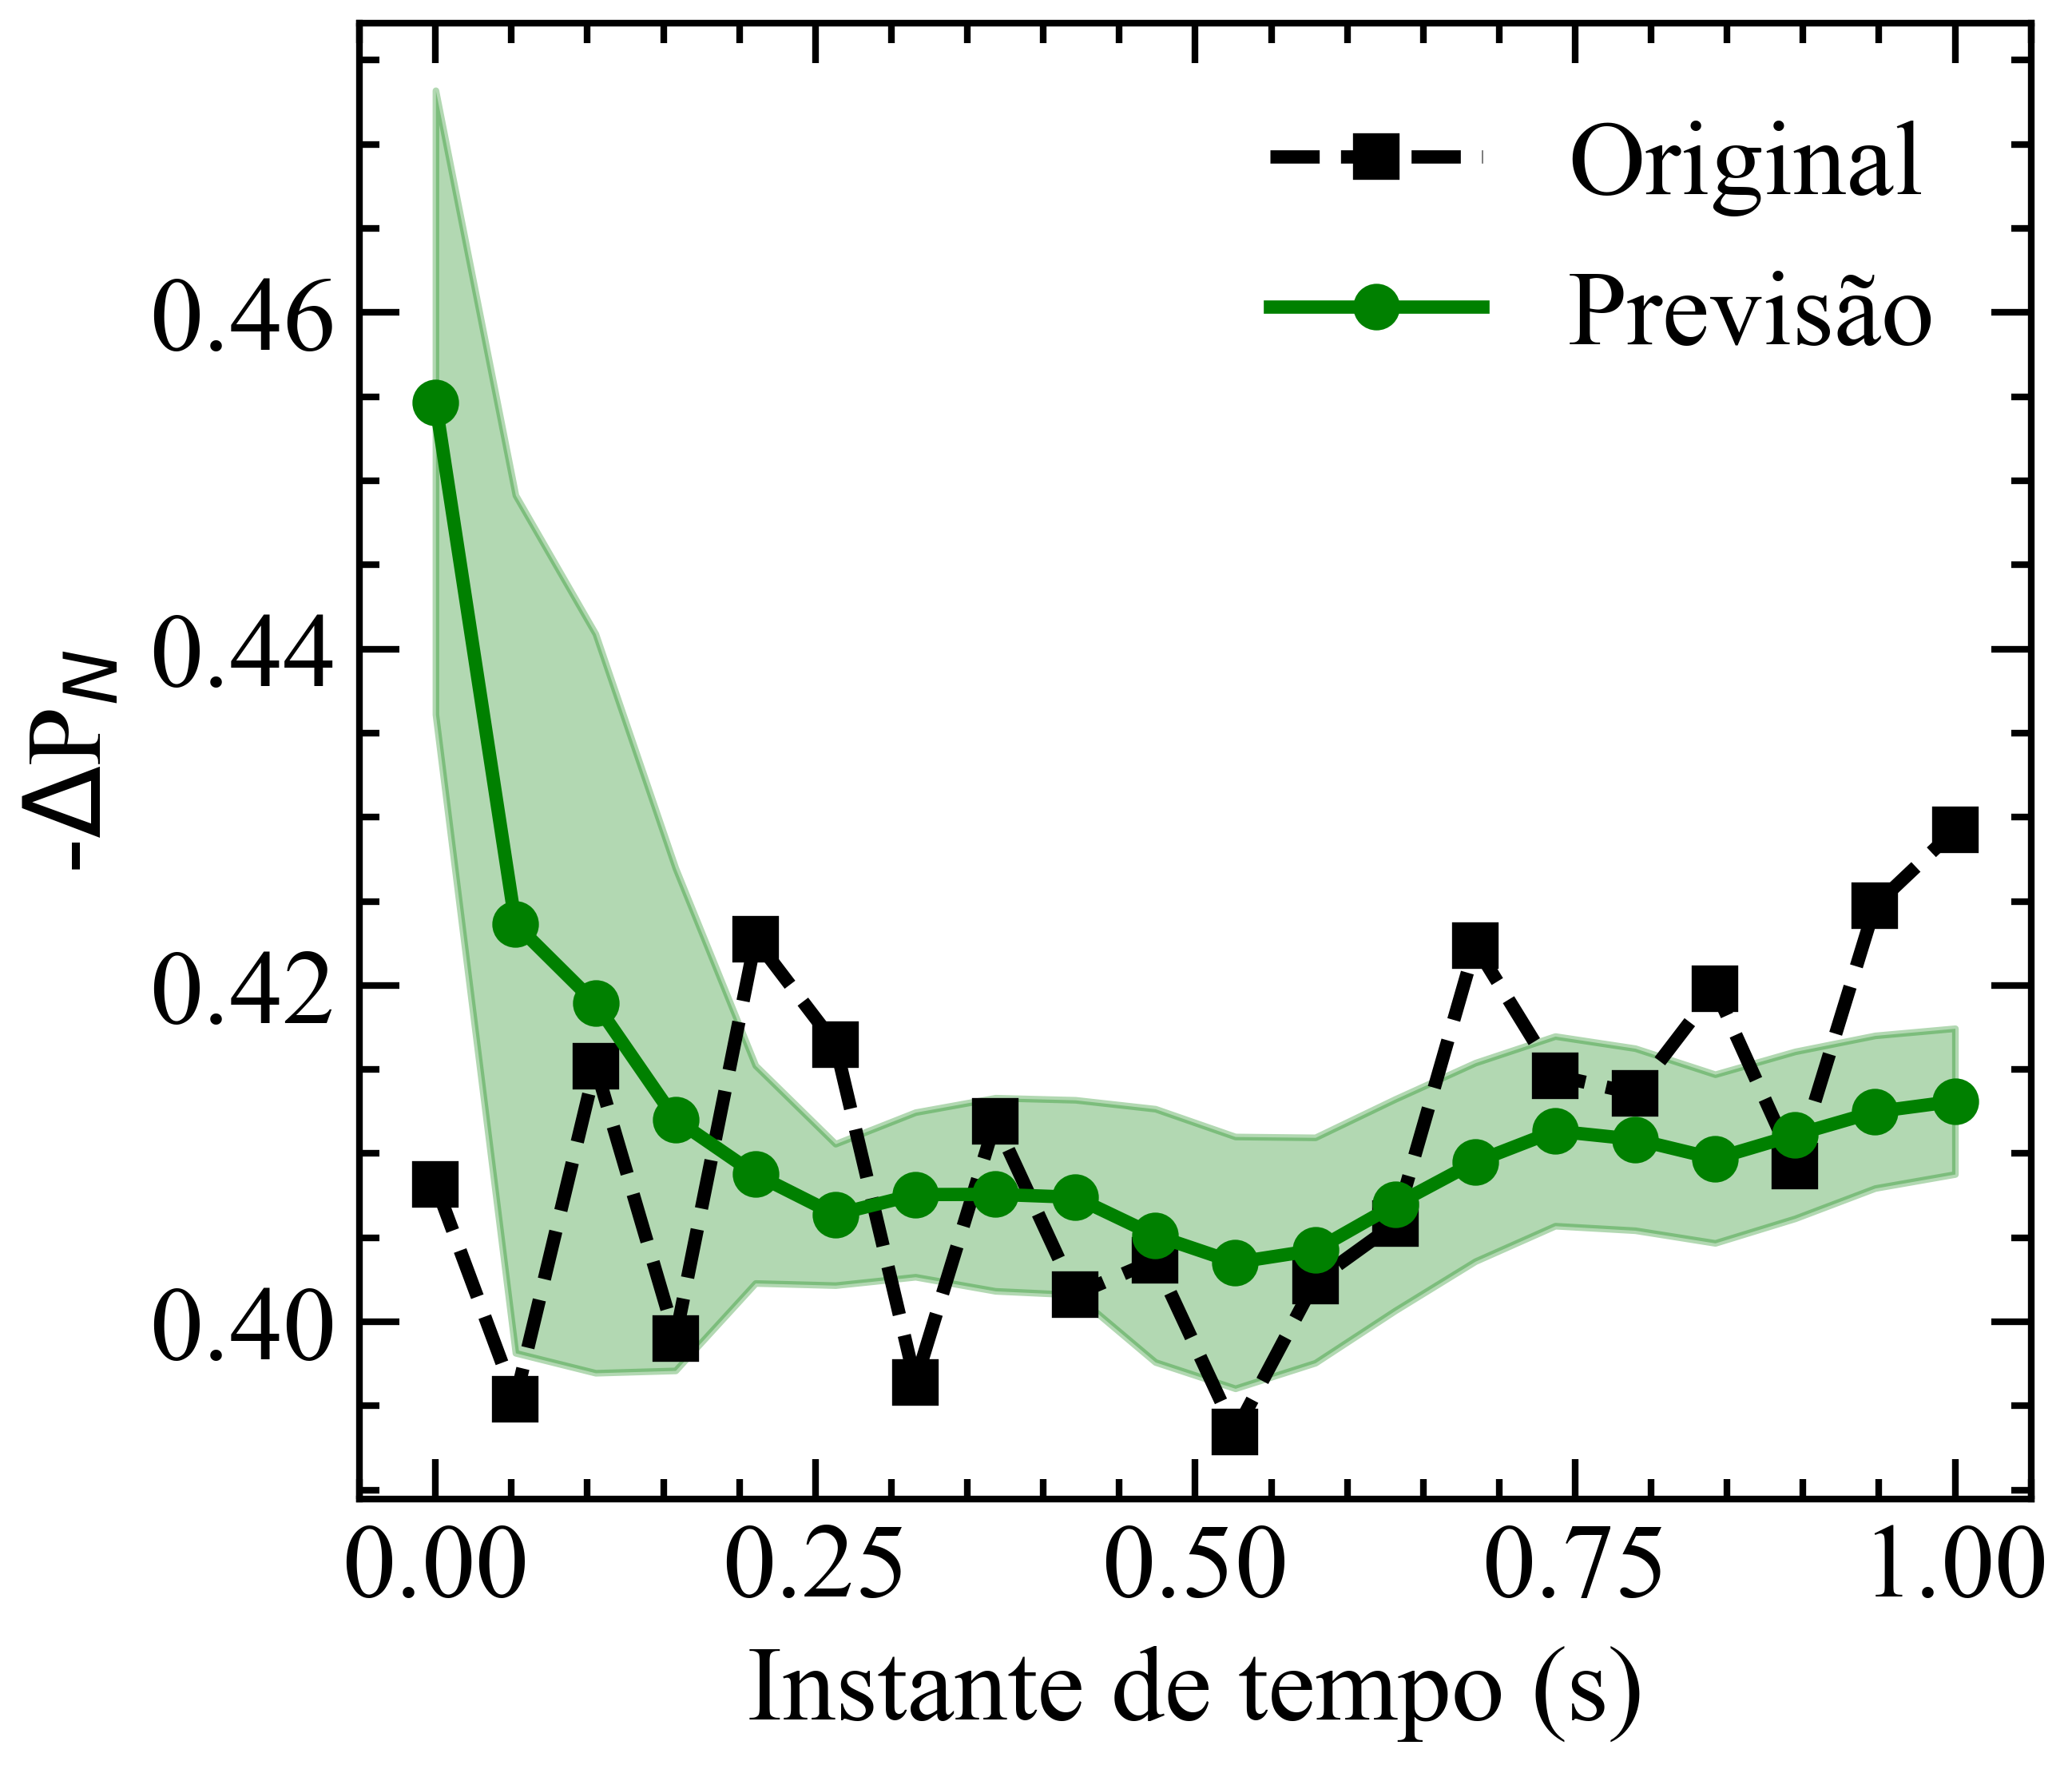

In [15]:
index: int = 6000
mean, std = mc_dropout_predict_parallel(
    seq2seq, np.expand_dims(Xnormal[index], 0), 10
)

plt.figure(figsize=(4.5, 4))
# plt.xticks(np.arange(0, 22, 2) * 1 / 20)
ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = np.linspace(0, 20, len(Xnormal[index])) * 1 / 20

plt.plot(x, Ynormal[index], label="Original", marker='s', ls='--')

plt.plot(x, mean.flatten(), label="Previsão", c="green", marker='o', ls='-')
plt.xlabel("Instante de tempo (s)")
plt.ylabel(r"-$\Delta$P$_N$")
plt.fill_between(x, ymin, ymax, alpha=0.3, color="green")
plt.legend()

plt.savefig("../images/seq2seq/normal_prediction.png", dpi=300, bbox_inches="tight");

In [16]:
print(index)
Xmenos[50].mean(), Xnormal[6000].mean()

6000


(0.059889114208051056, 0.0606182853691159)

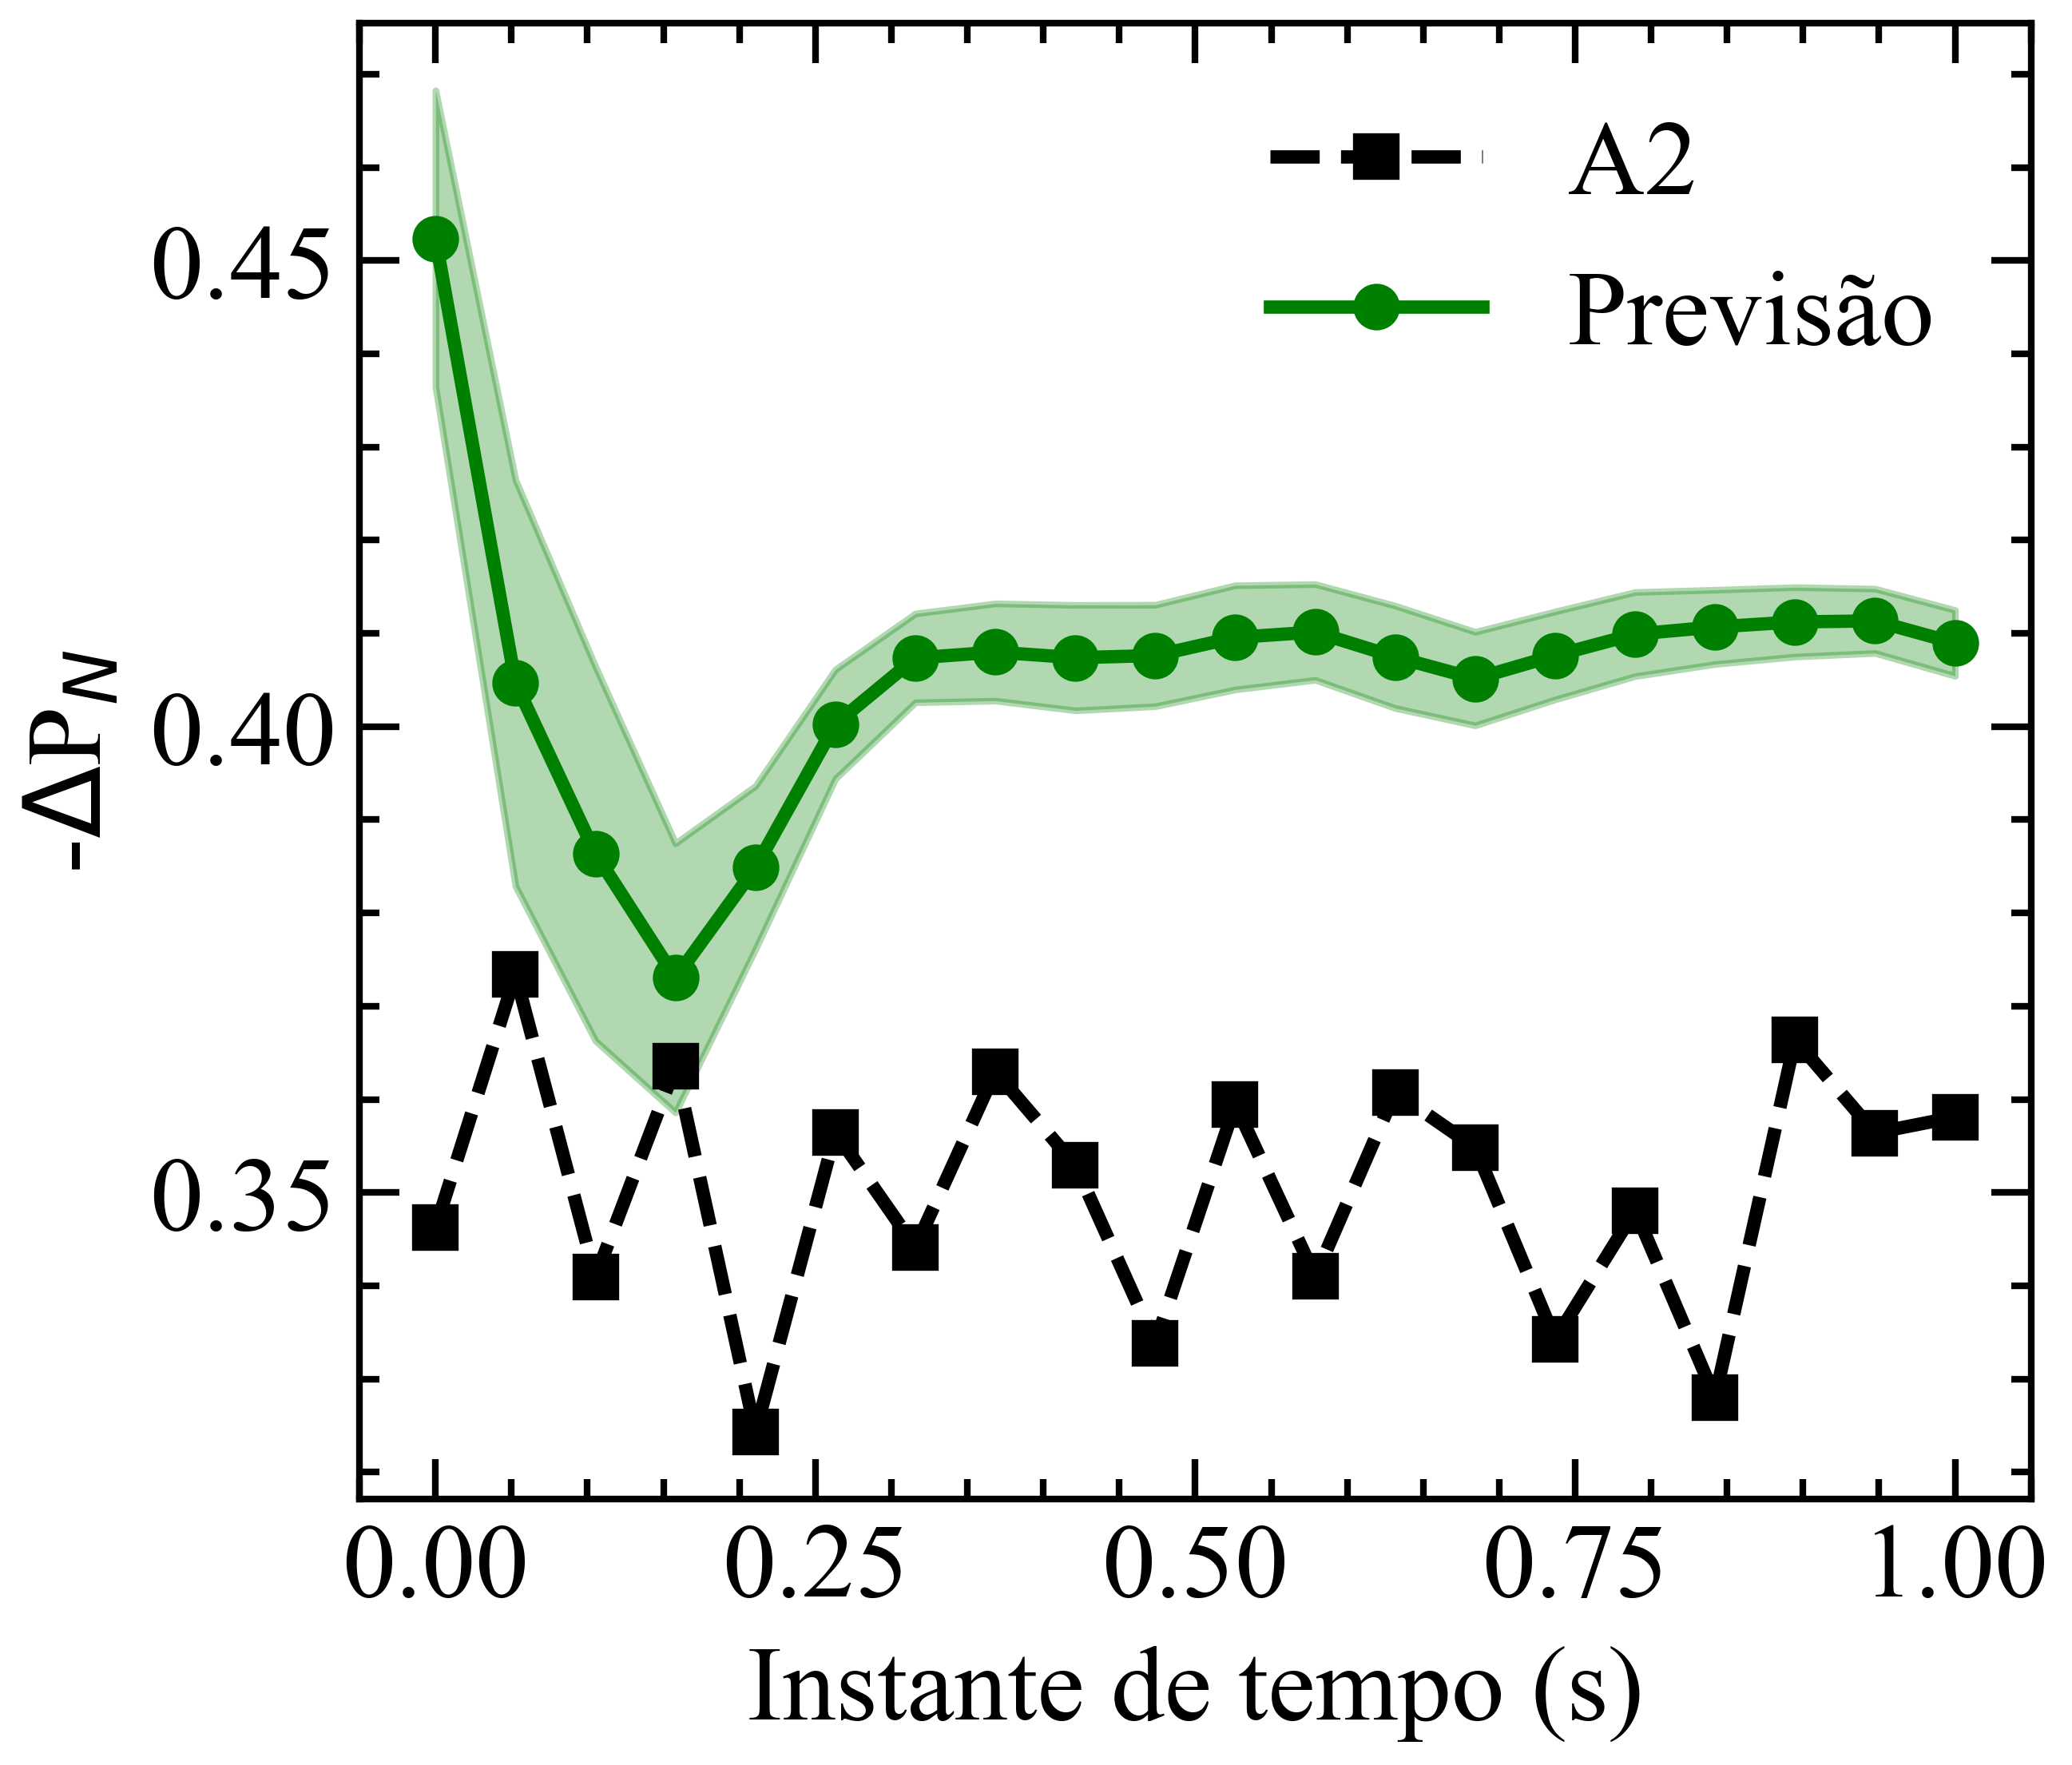

In [17]:
index: int = 50
mean, std = mc_dropout_predict_parallel(
    seq2seq, np.expand_dims(Xmenos[index], 0), 10
)

plt.figure(figsize=(4.5, 4))
# plt.xticks(np.arange(0, 22, 2) * 1 / 20)
ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = np.linspace(0, 20, len(Xmenos[index])) * 1 / 20

plt.plot(x, Ymenos[index], label="A2", marker='s', ls='--')
plt.plot(x, mean.flatten(), label="Previsão", c="green", marker='o', ls='-')

y_actual = Ymenos[index].flatten()
y_pred = mean.flatten()

# for i in range(len(x)):
#     plt.plot([x[i], x[i]], [y_actual[i], y_pred[i]], c="red", ls=":", alpha=0.3)

plt.xlabel("Instante de tempo (s)")
plt.ylabel(r"-$\Delta$P$_N$")
plt.fill_between(x, ymin, ymax, alpha=0.3, color="green")
plt.legend()

plt.savefig("../images/seq2seq/b3-200g_prediction.png", dpi=300, bbox_inches="tight");

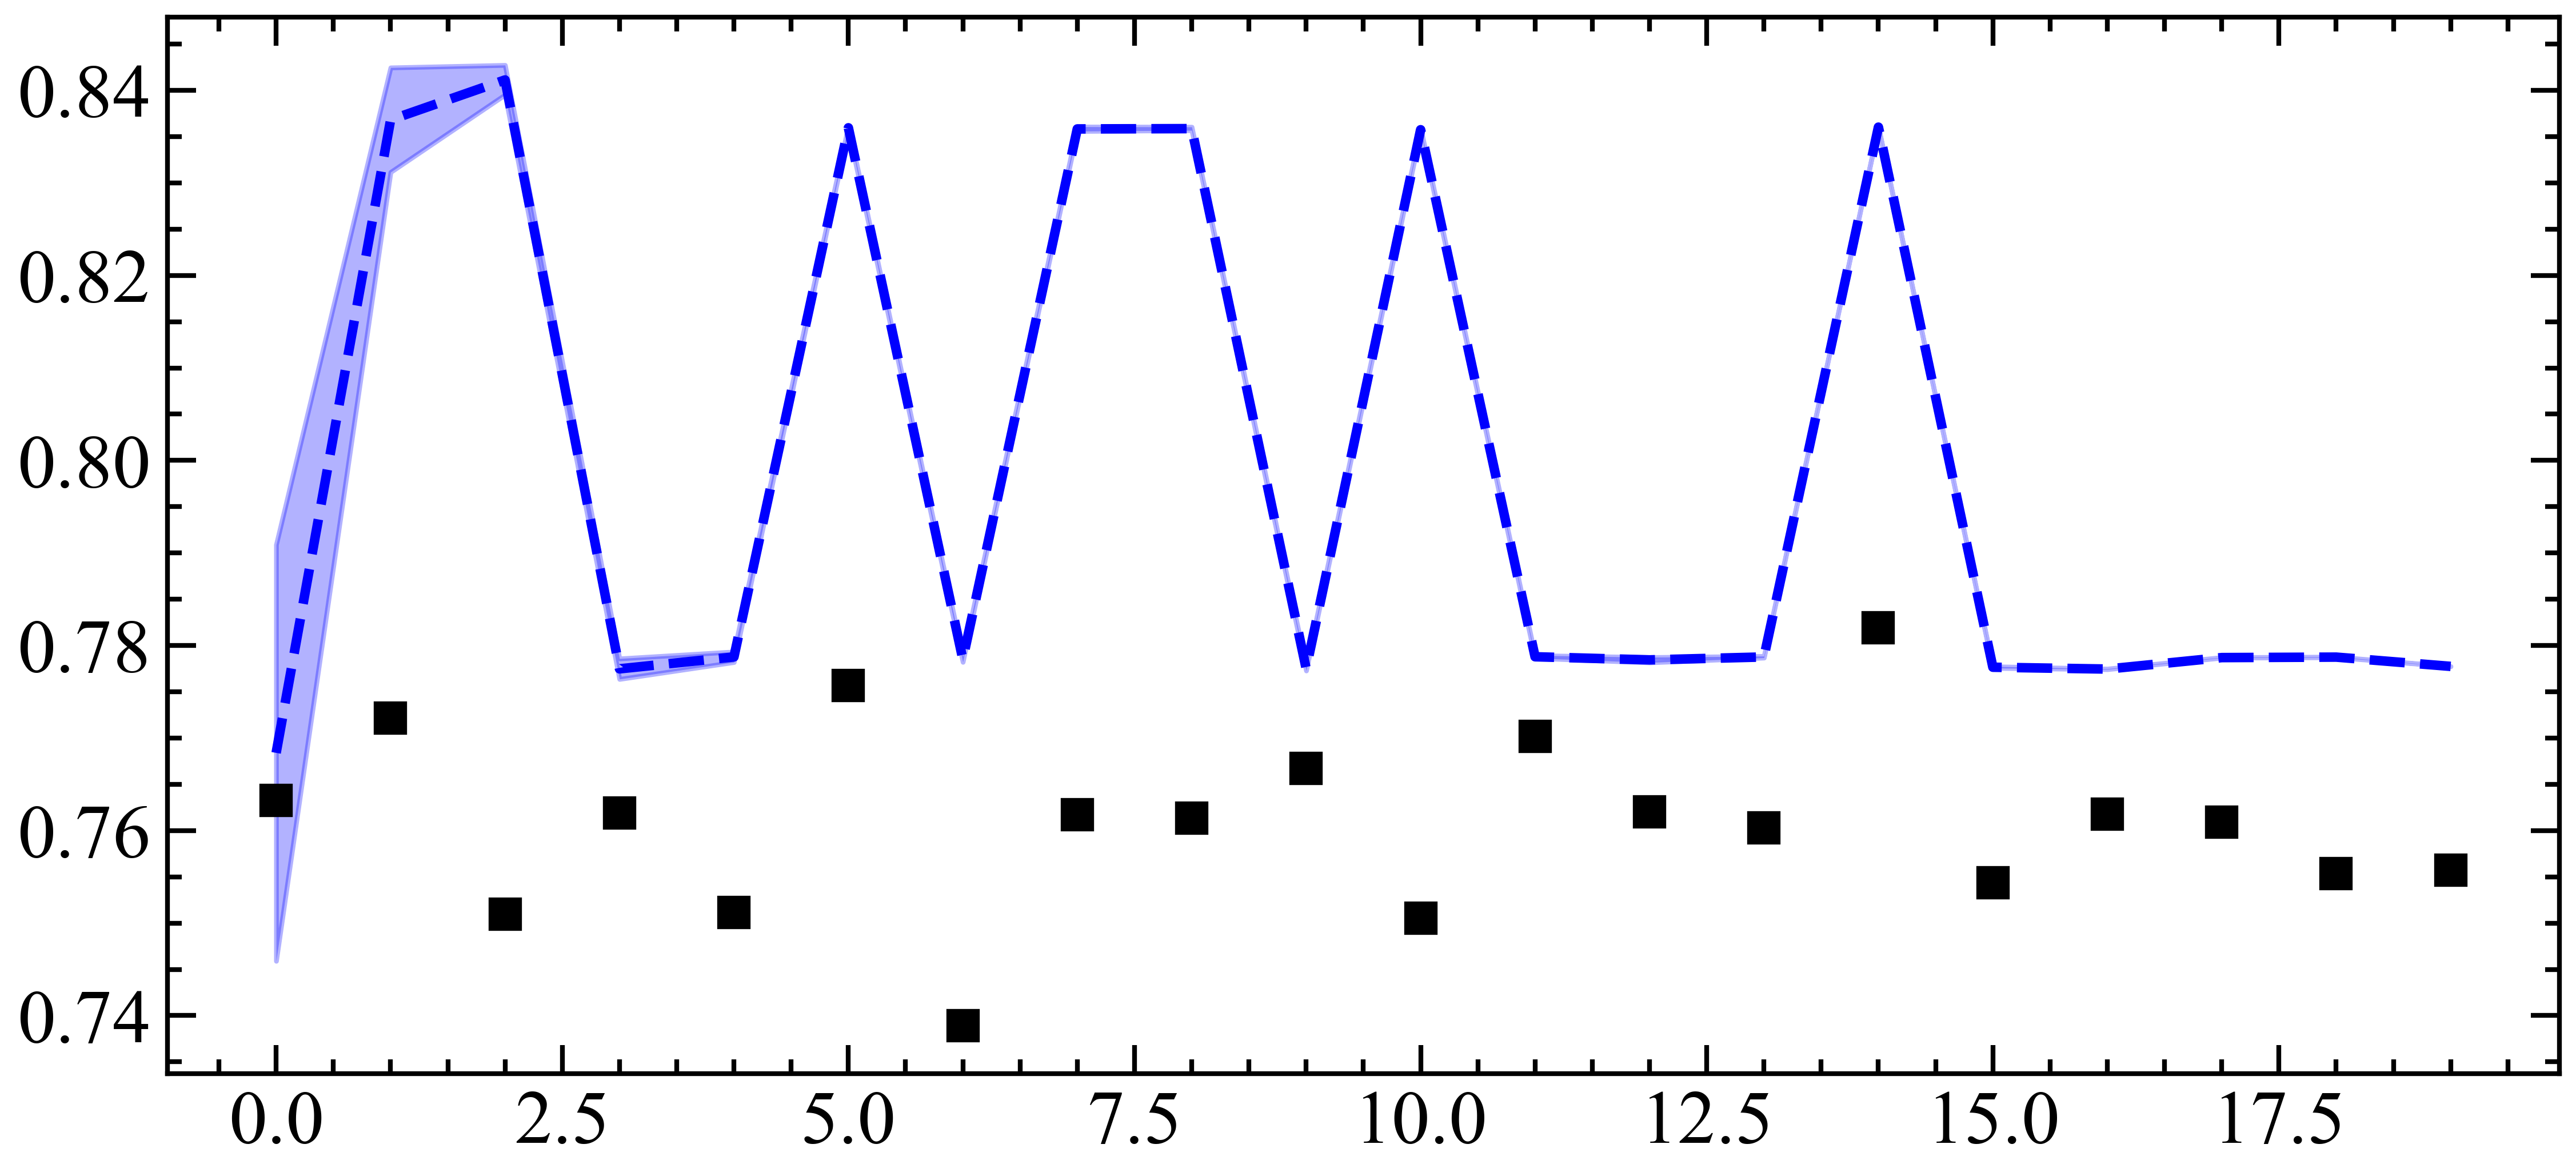

In [31]:
index: int = 1000
mean, std = mc_dropout_predict_parallel(
    seq2seq, Xpainco[index].reshape(1, DEFAULT_WS, 1), 10
)

ymin = (mean - std).flatten()
ymax = (mean + std).flatten()
x = range(DEFAULT_WS)

plt.plot(x, Ypainco[index], label="Normal", marker='s', ls='')
plt.plot(x, mean.flatten(), c='blue')
plt.fill_between(x, ymin, ymax, alpha=0.3, color="blue");